<a href="https://colab.research.google.com/github/dvignoles/nyc-transpo/blob/master/nyc_transpo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
from datetime import datetime, time
import numpy as np
import requests, zipfile, io, os, re, csv, warnings
import matplotlib.pyplot as plt
import preprocessing.constants as constants
import features.common.zones as zones
from IPython.display import clear_output
from preprocessing.taxi import get_parsed_df as get_parsed_taxi_df
from preprocessing.bike import get_parsed_df as get_parsed_bike_df
from preprocessing.common import clean_column_names

from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm


# Ignore the warnings about storing incompatible data types HDFStore
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

# Dataframe Loading/Cleaning/Features

In [0]:
def remove_outliers(df):
  # Remove anything over 6 hours
  return df[(df['tripduration'] < 60 * 60 * 5) & (df['trip_distance'] > 0) & (df['tripduration'] > 0)]

## Taxi Data
Since these downloads take a long time, do NOT reset all run times if you are not on localhost when it asks you to! It will wipe all downloaded files, and you'll have to download them again!

Note that the features are added in here as well for efficiency.

In [0]:
taxi_store = pd.HDFStore(constants.TAXI_DATA_PATH + '/dataframes.h5')

In [0]:
df_taxi_2013 = remove_outliers(get_parsed_taxi_df("2013", taxi_store))
df_taxi_2014 = remove_outliers(get_parsed_taxi_df("2014", taxi_store))
df_taxi_2015 = remove_outliers(get_parsed_taxi_df("2015", taxi_store))
df_taxi_2016 = remove_outliers(get_parsed_taxi_df("2016", taxi_store))
df_taxi_2017 = remove_outliers(get_parsed_taxi_df("2017", taxi_store))
df_taxi_2018 = remove_outliers(get_parsed_taxi_df("2018", taxi_store))
df_taxi_all = [df_taxi_2013, df_taxi_2014, df_taxi_2015, df_taxi_2016, df_taxi_2017, df_taxi_2018]

clear_output()

In [0]:
# Just like an open file, it must be closed to release the file lock.
taxi_store.close()

In [6]:
print(len(df_taxi_2013[(df_taxi_2013['tripduration'] < 60 * 60 * 60) & (df_taxi_2013['trip_distance'] > 0) & (df_taxi_2013['tripduration'] > 0)].index))
print(len(df_taxi_2013[df_taxi_2013['tripduration'] < 60*60*60].index))
print(len(df_taxi_2013.index))

2915301
2915301
2915301


## Citi Bike Data
Note that the features are added in here as well for efficiency.

In [0]:
bike_store = pd.HDFStore(constants.BIKE_DATA_PATH + '/dataframes.h5')

In [0]:
df_bike_2013 = remove_outliers(get_parsed_bike_df('2013', bike_store))
df_bike_2014 = remove_outliers(get_parsed_bike_df('2014', bike_store))
df_bike_2015 = remove_outliers(get_parsed_bike_df('2015', bike_store))
df_bike_2016 = remove_outliers(get_parsed_bike_df('2016', bike_store))
df_bike_2017 = remove_outliers(get_parsed_bike_df('2017', bike_store))
df_bike_2018 = remove_outliers(get_parsed_bike_df('2018', bike_store))
df_bike_all = [df_bike_2013, df_bike_2014, df_bike_2015, df_bike_2016, df_bike_2017, df_bike_2018]

clear_output()

In [0]:
bike_store.close()

## Features Not Yet Migrated
This still needs to be moved to the external py files of `features/bike.py` and `features/taxi.py` file - optimizations can be done first before moving it, perhaps?

### Zones / Neighborhoods
Define NYC taxi zone as a feature for all df

In [0]:
#attempt at adding zone_from_to to 2017 and 2018 taxi dataframes.  Results in a high # of nan vals?

def from_to_zid(from_id, to_id):
    try:
        return zones.ZONES_DIC[str(float(from_id))].name + ' to ' + zones.ZONES_DIC[str(float(to_id))].name
    except:
        return np.nan

def add_zones(df):
    df['zone_from'] = df['PULocationID']
    df['zone_to'] = df['DOLocationID']
    # df['zone_from_to'] = np.vectorize(from_to_zid)(df.zone_from, df.zone_to)

for df in [df_taxi_2017, df_taxi_2018]:
    add_zones(df)
    df.dropna(subset=['zone_from', 'zone_to'], inplace=True)


# Analysis

## Exploratory Data Analysis

### Trip Distance

In [11]:
# df_taxi_2015 contains some weirdly high trip distance outliers.

df_taxi_2015[df_taxi_2015.trip_distance > 500].count()

VendorID                 21
pickup_datetime          21
dropoff_datetime         21
passenger_count          21
trip_distance            21
pickup_longitude         21
pickup_latitude          21
RateCodeID               21
store_and_fwd_flag       21
dropoff_longitude        21
dropoff_latitude         21
payment_type             21
fare_amount              21
extra                    21
mta_tax                  21
tip_amount               21
tolls_amount             21
improvement_surcharge    21
total_amount             21
tripduration             21
zone_from                21
zone_to                  21
zone_from_to             21
day                      21
dtype: int64

bike mean:  1.2096165272983763
taxi mean:  2.9816797


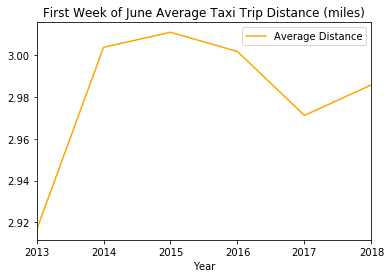

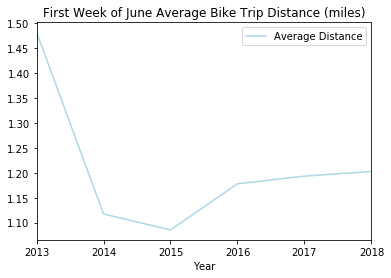

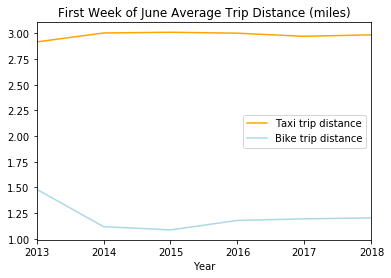

In [12]:
avg_trip_distance_bike = pd.DataFrame(
    {'Year': constants.YEARS,
     'Average Distance': [
         df_bike_2013.trip_distance.mean(),
         df_bike_2014.trip_distance.mean(),
         df_bike_2015.trip_distance.mean(),
         df_bike_2016.trip_distance.mean(),
         df_bike_2017.trip_distance.mean(),
         df_bike_2018.trip_distance.mean()
     ]})

print('bike mean: ',np.mean([df_bike_2013.trip_distance.mean(),
         df_bike_2014.trip_distance.mean(),
         df_bike_2015.trip_distance.mean(),
         df_bike_2016.trip_distance.mean(),
         df_bike_2017.trip_distance.mean(),
         df_bike_2018.trip_distance.mean()]))

avg_trip_distance_taxi = pd.DataFrame(
    {'Year': constants.YEARS,
     'Average Distance': [
         df_taxi_2013.trip_distance.mean(),
         df_taxi_2014.trip_distance.mean(),
         df_taxi_2015[df_taxi_2015.trip_distance < 500].trip_distance.mean(), # remove weirdly high trip distances...
         df_taxi_2016.trip_distance.mean(),
         df_taxi_2017.trip_distance.mean(),
         df_taxi_2018.trip_distance.mean()
     ]})

print('taxi mean: ',np.mean([df_taxi_2013.trip_distance.mean(),
         df_taxi_2014.trip_distance.mean(),
         df_taxi_2015[df_taxi_2015.trip_distance < 500].trip_distance.mean(), # remove weirdly high trip distances...
         df_taxi_2016.trip_distance.mean(),
         df_taxi_2017.trip_distance.mean(),
         df_taxi_2018.trip_distance.mean()]))

avg_trip_distance_taxi.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Taxi Trip Distance (miles)', color='orange')
avg_trip_distance_bike.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Bike Trip Distance (miles)', color='lightblue')

_ = avg_trip_distance_taxi.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Trip Distance (miles)', color='orange')
avg_trip_distance_bike.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Trip Distance (miles)', ax=_, color='lightblue')
_.legend(['Taxi trip distance', 'Bike trip distance'])

### Trip Duration

bike trip duration mean:  925.8797979741458
taxi trip duration mean: 863.4623884794918


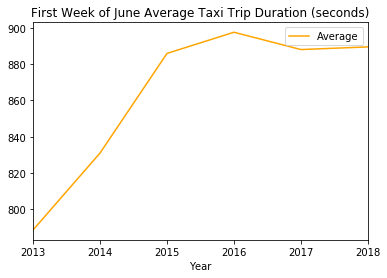

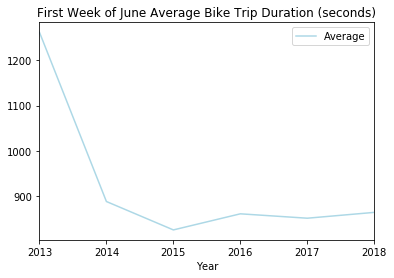

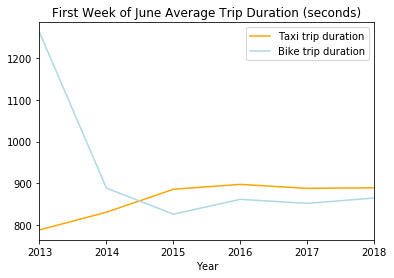

In [13]:
# Create average trip duration dataframes and plot

avg_trip_duration_bike = pd.DataFrame(
    {'Year': constants.YEARS, 
     'Average': [
        df_bike_2013.tripduration.mean(),
        df_bike_2014.tripduration.mean(),
        df_bike_2015.tripduration.mean(),
        df_bike_2016.tripduration.mean(),
        df_bike_2017.tripduration.mean(),
        df_bike_2018.tripduration.mean()] 
    })
print('bike trip duration mean: ',np.mean([
        df_bike_2013.tripduration.mean(),
        df_bike_2014.tripduration.mean(),
        df_bike_2015.tripduration.mean(),
        df_bike_2016.tripduration.mean(),
        df_bike_2017.tripduration.mean(),
        df_bike_2018.tripduration.mean()] ))

avg_trip_duration_taxi = pd.DataFrame(
    {'Year': constants.YEARS,
     'Average': [
         df_taxi_2013.tripduration.mean(),
         df_taxi_2014.tripduration.mean(),
         df_taxi_2015.tripduration.mean(),
         df_taxi_2016.tripduration.mean(),
         df_taxi_2017.tripduration.mean(),
         df_taxi_2018.tripduration.mean()]
    })

print('taxi trip duration mean:', np.mean([
         df_taxi_2013.tripduration.mean(),
         df_taxi_2014.tripduration.mean(),
         df_taxi_2015.tripduration.mean(),
         df_taxi_2016.tripduration.mean(),
         df_taxi_2017.tripduration.mean(),
         df_taxi_2018.tripduration.mean()]))

avg_trip_duration_taxi.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Taxi Trip Duration (seconds)', color='orange')

avg_trip_duration_bike.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Bike Trip Duration (seconds)', color='lightblue')

_ = avg_trip_duration_taxi.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Trip Duration (seconds)', color='orange')
avg_trip_duration_bike.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Trip Duration (seconds)', ax=_, color='lightblue')
_.legend(['Taxi trip duration', 'Bike trip duration'])


#fig.savefig('trip_duration.jpg')

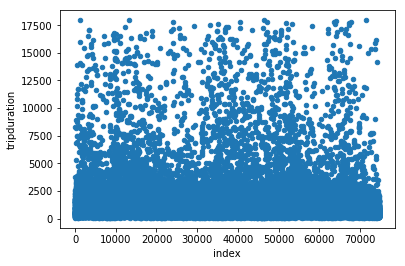

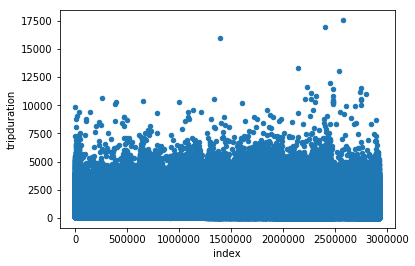

In [14]:
# quick scatter plot--exposes some weird outliers.  
# CitiBike has some >1000 hour trips
# Cabs have some negative time durations

df_bike_2013.reset_index().plot(kind='scatter', x='index', y='tripduration')

df_taxi_2013.reset_index().plot(kind='scatter', x='index', y='tripduration')

### CitiBike rider age

In [15]:
# had to avoid 2014 here, as there are some issues with the birthdate field in that dataframe. Will clean.
# yo people in their 40s love citibikes

citi_avg_age = []

citi_avg_age.append(df_bike_2013["birth_year"].mean())
citi_avg_age.append("NaN")
citi_avg_age.append(df_bike_2015["birth_year"].mean())
citi_avg_age.append(df_bike_2016["birth_year"].mean())
citi_avg_age.append(df_bike_2017["birth_year"].mean())
citi_avg_age.append(df_bike_2018["birth_year"].mean())

print(citi_avg_age)

[1973.768541887161, 'NaN', 1976.320321699859, 1977.48909828384, 1978.7112779676524, 1978.749907413158]


### Number of Trips

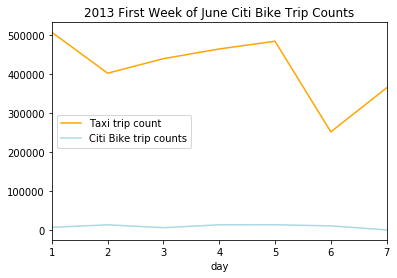

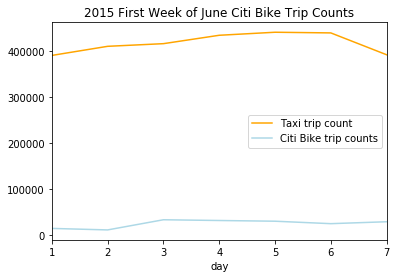

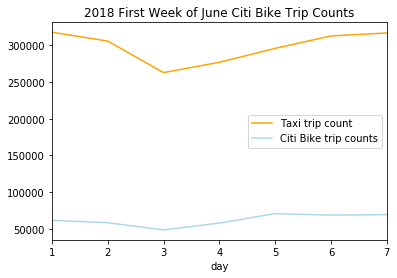

In [16]:
first_plot = df_taxi_2013.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2013 First Week of June Taxi Trip Counts', color='orange')
df_bike_2013.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2013 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

first_plot = df_taxi_2015.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2015 First Week of June Taxi Trip Counts', color='orange')
df_bike_2015.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2015 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

first_plot = df_taxi_2018.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2018 First Week of June Taxi Trip Counts', color='orange')
df_bike_2018.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2018 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

In [0]:
# Make new data frames for yearly trip counts, and graph them

df_taxi_trip_counts = pd.DataFrame({'Year': constants.YEARS, 'Count': [
    df_taxi_2013.groupby(by='day').size().sum(),
    df_taxi_2014.groupby(by='day').size().sum(),
    df_taxi_2015.groupby(by='day').size().sum(),
    df_taxi_2016.groupby(by='day').size().sum(),
    df_taxi_2017.groupby(by='day').size().sum(),
    df_taxi_2018.groupby(by='day').size().sum(),
]})

df_bike_trip_counts = pd.DataFrame({'Year': constants.YEARS, 'Count': [
    df_bike_2013.groupby(by='day').size().sum(),
    df_bike_2014.groupby(by='day').size().sum(),
    df_bike_2015.groupby(by='day').size().sum(),
    df_bike_2016.groupby(by='day').size().sum(),
    df_bike_2017.groupby(by='day').size().sum(),
    df_bike_2018.groupby(by='day').size().sum(),
]})

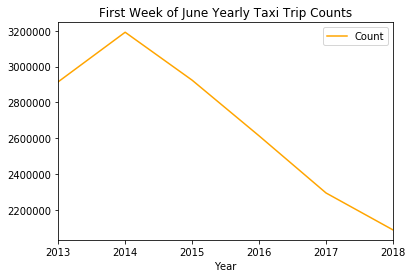

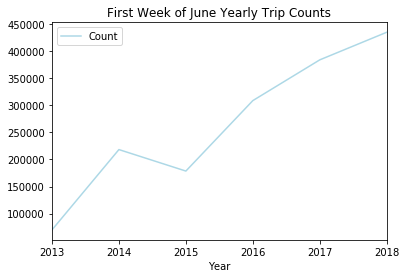

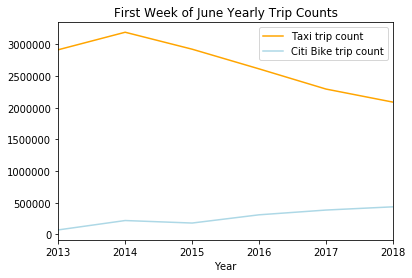

In [18]:
df_taxi_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Taxi Trip Counts', color='orange')
df_bike_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Trip Counts', color='lightblue') 

first_plot = df_taxi_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Taxi Trip Counts', color='orange')
df_bike_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip count'])

#### Popular Routes

In [19]:
print('10 most frequent inter-zone trips by Taxi')
df_taxi_2016[df_taxi_2016.zone_from != df_taxi_2016.zone_to].zone_from_to.value_counts()[0:10]

10 most frequent inter-zone trips by Taxi


Central Park to Midtown Center         40188
Midtown Center to Central Park         38265
Clinton East to Central Park           30968
Central Park to Clinton East           26951
East Chelsea to Clinton East           24657
Lincoln Square East to Central Park    20585
Clinton East to East Chelsea           20474
Central Park to Midtown East           20450
Midtown East to Central Park           20422
Clinton East to Midtown Center         19474
Name: zone_from_to, dtype: int64

In [20]:
print('10 most frequent inter-zone trips by Bike')
df_bike_2016[df_bike_2016.zone_from != df_bike_2016.zone_to].zone_from_to.value_counts()[0:10]

10 most frequent inter-zone trips by Bike


Clinton East to East Chelsea               3048
East Chelsea to Clinton East               2753
Central Park to Clinton East               2102
Greenwich Village North to East Village    1945
East Village to Greenwich Village North    1928
Clinton East to Central Park               1830
Clinton East to Midtown Center             1817
Greenwich Village North to East Chelsea    1814
Central Park to Midtown Center             1809
East Village to Alphabet City              1762
Name: zone_from_to, dtype: int64

In [21]:
print('10 most frequent trips by Bike')
df_bike_2016.zone_from_to.value_counts()[0:10]

10 most frequent trips by Bike


Central Park to Central Park                          11676
East Chelsea to East Chelsea                           6595
Clinton East to Clinton East                           3629
Clinton East to East Chelsea                           3048
East Chelsea to Clinton East                           2753
East Village to East Village                           2239
Central Park to Clinton East                           2102
Greenwich Village North to East Village                1945
East Village to Greenwich Village North                1928
Greenwich Village North to Greenwich Village North     1860
Name: zone_from_to, dtype: int64

In [22]:
print('10 most frequent trips by Taxi')
df_taxi_2016.zone_from_to.value_counts()[0:10]

10 most frequent trips by Taxi


Central Park to Central Park           232433
Central Park to Midtown Center          40188
Midtown Center to Central Park          38265
East Chelsea to East Chelsea            31265
Clinton East to Central Park            30968
Central Park to Clinton East            26951
East Chelsea to Clinton East            24657
Clinton East to Clinton East            23454
Lincoln Square East to Central Park     20585
Clinton East to East Chelsea            20474
Name: zone_from_to, dtype: int64

In [23]:
print('Most common trips to Manhattanville (City College) Zone by Taxi 2016\n')

zone_from = df_taxi_2016[df_taxi_2016.zone_to == 152.0].zone_from.value_counts().index[0:10]
for zone_id in zone_from:
    z = constants.ZONES_DIC[str(zone_id)]
    print(z.name,'to Manhattanville')

Most common trips to Manhattanville (City College) Zone by Taxi 2016

Central Park to Manhattanville
Bloomingdale to Manhattanville
Clinton East to Manhattanville
Central Harlem North to Manhattanville
Central Harlem to Manhattanville
East Chelsea to Manhattanville
Manhattanville to Manhattanville
Lincoln Square East to Manhattanville
East Harlem North to Manhattanville
Midtown Center to Manhattanville


## REGRESSION CLEANING

In [0]:
times = []
for i in range(0, 24):
    times.append(time(i, 0, 0))
    times.append(time(i, 30, 0))

def time_to_val(t):
    for index, time in enumerate(times):
        if (t < time):
            return (index - 1)
    return 47

In [0]:
#extract time from datetime

for df in df_bike_all:
  df.loc[:,'is_bike'] = 1
#  df.loc[:,'start_time'] = df['starttime'].apply(lambda x: time_to_val(x.time()))
#  df.loc[:,'stop_time'] = df['stoptime'].apply(lambda x: time_to_val(x.time()))

for df in df_taxi_all:
  df.loc[:, 'is_bike'] = 0
#  df.loc[:,'start_time'] = df['pickup_datetime'].apply(lambda x: time_to_val(x.time()))
#  df.loc[:,'stop_time'] = df['dropoff_datetime'].apply(lambda x: time_to_val(x.time()))


In [0]:
# concat the two dataframes
dfs_2013 = pd.concat([df_taxi_2013, df_bike_2013], sort=True)
dfs_2014 = pd.concat([df_taxi_2014, df_bike_2014], sort=True)
dfs_2015 = pd.concat([df_taxi_2015, df_bike_2015], sort=True)
dfs_2016 = pd.concat([df_taxi_2016, df_bike_2016], sort=True)
dfs_2017 = pd.concat([df_taxi_2017, df_bike_2017], sort=True)
dfs_2018 = pd.concat([df_taxi_2018, df_bike_2018], sort=True)


In [0]:
features=['trip_distance', 'is_bike']
target = 'tripduration'
df_model = dfs_2018
df_model = df_model
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

#print('Intercept: \n', regr.intercept_)
#print('Coefficients: \n', regr.coef_)
print("R^2: " + str(regr.score(X_test, y_test)))

R^2: 0.5444096515804493


In [29]:
# with statsmodels
est = sm.OLS(y_train, sm.add_constant(X_train)).fit()

print_model = est.summary()
print(print_model)

/home/madmin/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:           tripduration   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                 1.100e+06
Date:                Tue, 14 May 2019   Prob (F-statistic):               0.00
Time:                        18:39:47   Log-Likelihood:            -1.5455e+07
No. Observations:             2018406   AIC:                         3.091e+07
Df Residuals:                 2018403   BIC:                         3.091e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           439.0250      0.499    879.704